In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import sys,os
sys.path.append('../../')
sys.path.append('../../pyathena/')
import pyathena as pa
import tigradpy as tp
print(tp.__all__)

['add_fields', 'mass_to_lum', 'read_athinput', 'read_hst', 'read_starpar_vtk', 'read_zprof', 'read_zprof_all', 'units', 'yt_multipanel']


In [2]:
MtoL = tp.mass_to_lum()
u = tp.units()

__Max main-sequence age, mean luminosity for individual stars using power-law approximation to Padova stellar evolutionary track. (Table 1 in Parravano et al. 2003)__

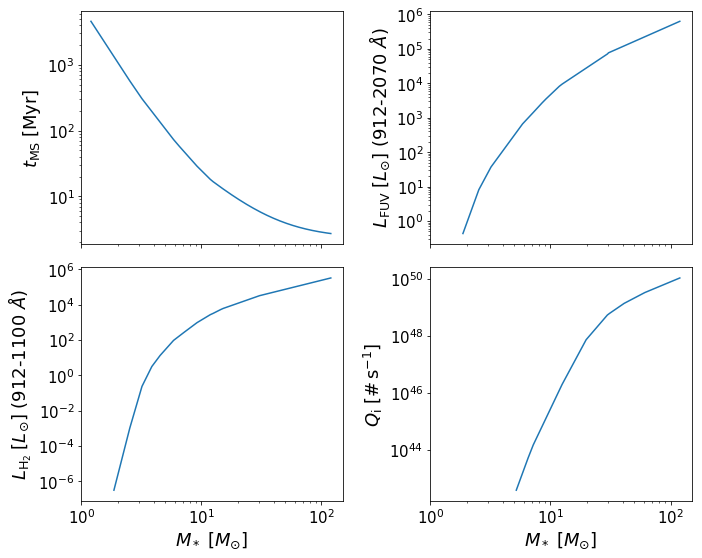

In [3]:
mass = np.linspace(1.2, 200.0, 300)

mpl.rcParams['font.size'] = 15.0
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()
plt.sca(axes[0])
plt.loglog(mass, MtoL.calc_tMS(mass))
plt.ylabel(r'$t_{\rm MS}\;[{\rm Myr}]$')
plt.sca(axes[1])
plt.loglog(mass, MtoL.calc_LFUV(mass))
plt.ylabel(r'$L_{\rm FUV}\;[L_{\odot}]$ (912-2070 $\AA$)')
plt.sca(axes[2])
plt.loglog(mass, MtoL.calc_LH2(mass))
plt.xlabel(r'$M_*\;[M_{\odot}]$')
plt.ylabel(r'$L_{{\rm{H}_2}}\;[L_{\odot}]$ (912-1100 $\AA$)')
plt.sca(axes[3])
plt.loglog(mass, MtoL.calc_Qi(mass))
plt.xlabel(r'$M_*\;[M_{\odot}]$')
plt.ylabel(r'$Q_{\rm i}\;[\#\,{\rm s}^{-1}]$')
plt.xlim(1,150)
plt.tight_layout()

In [9]:
def get_Qi(datadir, model, num, teject=5.0, agemax=40.0):
    fname = os.path.join(datadir,\
         '{0:s}.{1:04d}.starpar.vtk'.format(model,num))
    sp = tp.read_starpar_vtk(fname, force_override=False)
    sp_cl = sp[(sp.mass > 0.0) & (sp.age < agemax*u.Myr.value)]
    Qi_cl = MtoL.calc_Qi_SB99(sp_cl['mass']*u.Msun.value, sp_cl['mage']*u.Myr)
    
    sp_ru = sp[sp.mass == 0.0]
    tMS = np.array((sp_ru.mage - sp_ru.age)) + teject
    mass_est = MtoL.calc_ZAMS_mass(tMS)
    Qi_ru = MtoL.calc_Qi(mass_est)
    
    return sp.time, Qi_cl.sum(), Qi_ru.sum()

def get_Qi_all(datadir, model, num, teject=5.0, agemax=40.0):
    time = []
    Qi_cl = []
    Qi_ru = []
    for num_ in num:
        time_, Qi_cl_, Qi_ru_ = get_Qi(datadir, model, num_,
                                       teject=teject, agemax=agemax)
        time.append(time_)
        Qi_cl.append(Qi_cl_)
        Qi_ru.append(Qi_ru_)
    time = np.array(time)
    Qi_cl = np.array(Qi_cl)
    Qi_ru = np.array(Qi_ru)
    return time, Qi_cl, Qi_ru

Text(0,0.5,'runaway contribution to Qi_tot')

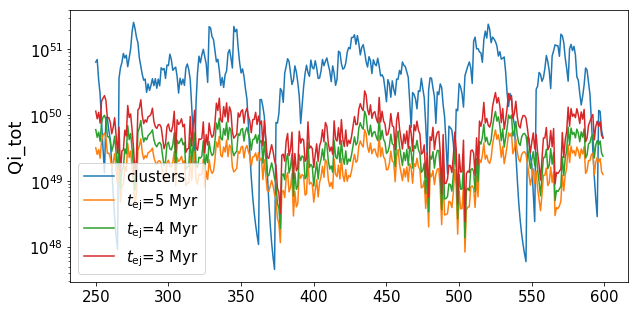

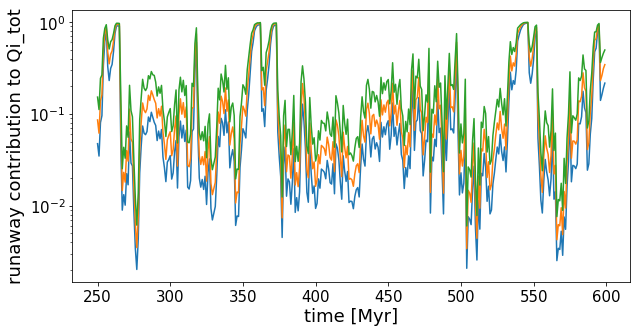

In [36]:
model = 'R8_4pc_newacc'
#datadir = os.path.join('/tigress/jk11/radps_postproc',model)
spdir = '/tigress/changgoo/R8_4pc_newacc/starpar'
num = range(250, 600)

time, Qi_cl, Qi_ru1 = get_Qi_all(spdir, model, num, teject=5.0, agemax=40.0)
time, Qi_cl, Qi_ru2 = get_Qi_all(spdir, model, num, teject=4.0, agemax=40.0)
time, Qi_cl, Qi_ru3 = get_Qi_all(spdir, model, num, teject=3.0, agemax=40.0)
plt.figure(figsize=(10,5))
plt.plot(time, Qi_cl, label=r'clusters')
plt.plot(time, Qi_ru1, label=r'$t_{\rm ej}$=5 Myr')
plt.plot(time, Qi_ru2, label=r'$t_{\rm ej}$=4 Myr')
plt.plot(time, Qi_ru3, label=r'$t_{\rm ej}$=3 Myr')
plt.yscale('log')
plt.legend(loc=3)
plt.ylabel('Qi_tot')
plt.figure(figsize=(10,5))
plt.plot(time, Qi_ru1/(Qi_cl+Qi_ru1), label=r'$t_{\rm ej}$=5 Myr')
plt.plot(time, Qi_ru2/(Qi_cl+Qi_ru2), label=r'$t_{\rm ej}$=4 Myr')
plt.plot(time, Qi_ru3/(Qi_cl+Qi_ru3), label=r'$t_{\rm ej}$=3 Myr')
plt.yscale('log')
plt.xlabel('time [Myr]')
plt.ylabel('runaway contribution to Qi_tot')

* __Make a toy model for simple stellar population using Padova mass-luminosity relation__

* __For L_FUV, consider all stars with $M > 1.8 M_{\odot}$__

* __For Qi, consider all stars with $M > 5.0 M_{\odot}$.__

__Kroupa IMF__

Tools to work with IMF: https://github.com/keflavich/imf


In [22]:
sys.path.append(os.path.join(os.path.expanduser('~'),'imf'))
import imf 
kroupa = imf.Kroupa()

mmax = 120.0
cutoff0 = 5.0
cutoff1 = 1.8
mfrac_over_cutoff0 = (kroupa.m_integrate(cutoff0, mmax)[0] /
                     kroupa.m_integrate(kroupa.mmin, mmax)[0])
mfrac_over_cutoff1 = (kroupa.m_integrate(cutoff1, mmax)[0] /
                     kroupa.m_integrate(kroupa.mmin, mmax)[0])

print('kroupa - slopes',kroupa.p1,kroupa.p2,kroupa.p3)
print('kroupa - break1, break2',kroupa.break1,kroupa.break2)
print('kroupa-mmin, mmax',kroupa.mmin,kroupa.mmax)
print('m_cutoff0,mfrac_over_cutoff0',cutoff0,mfrac_over_cutoff0)
print('m_cutoff1,mfrac_over_cutoff1',cutoff1,mfrac_over_cutoff1)

('kroupa - slopes', 0.3, 1.3, 2.3)
('kroupa - break1, break2', 0.08, 0.5)
('kroupa-mmin, mmax', 0.03, 120)
('m_cutoff0,mfrac_over_cutoff0', 5.0, 0.2663895245589496)
('m_cutoff1,mfrac_over_cutoff1', 1.8, 0.421849044893804)


In [31]:
def pull_runawaymass (N, lmass=0.5, hmass=120.):
    '''
    Inverse transform sampling with a Salpeter IMF
    '''
    from scipy.integrate import quad, trapz

    _imf = lambda x: x**-2.35
    Z = quad(_imf, lmass, hmass)[0]
    pdf = lambda x: _imf(x)/Z
    #cdf = lambda mass: (Z*-1.35)**-1 * (mass**-1.35 - 8.**-1.35)
    inv_cdf = lambda rv: (-1.35*Z*rv + lmass**-1.35)**(1/-1.35)

    mass_pulls = inv_cdf ( np.random.uniform(0,1,N))
    return pdf,mass_pulls

pdf,mass0 = pull_runawaymass(20000, lmass=cutoff0)
pdf,mass1 = pull_runawaymass(20000, lmass=cutoff1)
agemax0 = MtoL.calc_tMS(mass0)
agemax1 = MtoL.calc_tMS(mass1)
age = np.arange(0.0, 40.0, 0.1)
Qitot = []
LFUVtot = []
MtoL.model = 'Padova'
for age_ in age:
    mass = mass0[agemax0 > age_]
    Qitot.append(MtoL.calc_Qi(mass).sum())
    mass = mass1[agemax1 > age_]
    LFUVtot.append(MtoL.calc_LFUV(mass).sum())
    
Xi = mfrac_over_cutoff0*np.array(Qitot)/mass0.sum()
Psi = mfrac_over_cutoff0*np.array(LFUVtot)/mass1.sum()

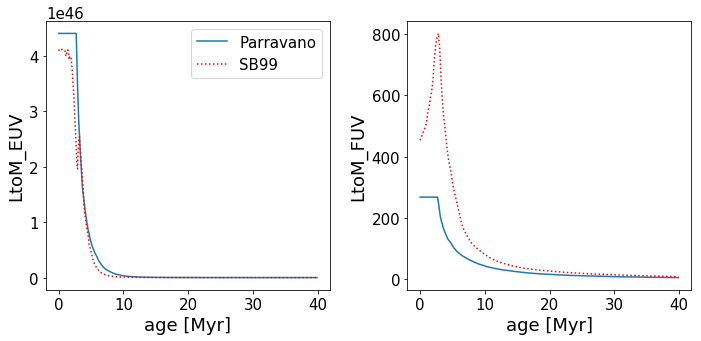

In [32]:
# overplot SB99 result using red dotted lines
MtoL.model = 'SB99'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axes[0])
plt.plot(age, Xi, label='Parravano')
plt.plot(age, MtoL.calc_Qi_SB99(1.0, age), 'r:', label='SB99')
plt.xlabel('age [Myr]')
plt.ylabel('LtoM_EUV')
plt.legend()
plt.sca(axes[1])
plt.plot(age, Psi)
plt.plot(age, MtoL.calc_LFUV_SB99(1.0, age), 'r:')
plt.xlabel('age [Myr]')
plt.ylabel('LtoM_FUV')
plt.tight_layout()

__(Present-day) mass fn of runaways and luminosity fns of runaways (blue) and clusters (orange)__

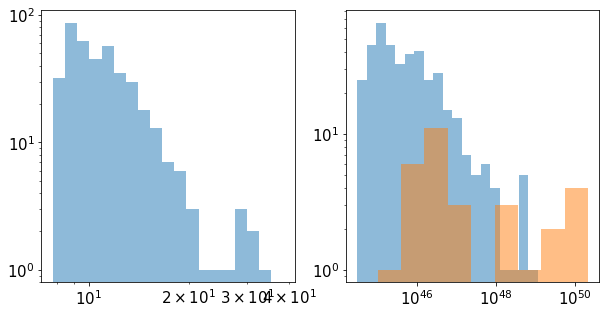

In [20]:
alpha = 0.5
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(sp_ru['mass_est'],
         bins=np.logspace(np.log10(sp_ru['mass_est'].min()),
                          np.log10(sp_ru['mass_est'].max()), num=20), alpha=alpha)
#plt.hist(sp_cl['mass'],
#         bins=np.logspace(np.log10(sp_cl['mass'].min()),
#                          np.log10(sp_cl['mass'].max()), num=10), alpha=alpha)

plt.xscale('log')
plt.yscale('log')
plt.subplot(122)
plt.hist(sp_ru['Qi'],
         bins=np.logspace(np.log10(sp_ru['Qi'].min()),
                          np.log10(sp_ru['Qi'].max()), num=20), alpha=alpha)
plt.hist(sp_cl['Qi'],
         bins=np.logspace(np.log10(sp_cl['Qi'].min()),
                          np.log10(sp_cl['Qi'].max()), num=10), alpha=alpha)
plt.xscale('log')
plt.yscale('log')
#plt.tight_layout()